In [1]:
import tensorflow as tf
import pickle
from PIL import Image
import os
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import cv2

### Preproccess Imgs

In [66]:
def crop_and_warp(cv2_img):
    '''crop the background off and warp the card into a perfect rectangle'''
    original = cv2_img.copy()

    # convert to grayscale and threshold
    gray = cv2.cvtColor(cv2_img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)

    # find edges
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # get the largest contour (probably the card)
    card_contour = max(contours, key=cv2.contourArea)

    # turn the contour to polygon
    peri = cv2.arcLength(card_contour, True)
    tolerance = 0.02 * peri   # how big of gaps in our contour do we allow (2% of the perimeter)
    approx_poly = cv2.approxPolyDP(card_contour, tolerance, True)

    # if more than 4 corners, something is wrong
    assert len(approx_poly) == 4, "The detected contour has more than 4 corners."
    pts = approx_poly.reshape(4, 2) # reshape to 4 (x,y) pairs

    # get corners
    yx_sum = pts.sum(axis=1)
    yx_diff = np.diff(pts, axis=1)
    tl = pts[np.argmin(yx_sum)] # tl because min x+y
    br = pts[np.argmax(yx_sum)] # br because max x+y
    tr = pts[np.argmin(yx_diff)] # tr because min y-x
    bl = pts[np.argmax(yx_diff)] # bl because max y-x
    warped_rect = np.array([tl, tr, br, bl], dtype="float32")

    # Compute width and height of new image
    # euclidean distance between points
    w = int(np.linalg.norm(br - bl)) 
    h = int(np.linalg.norm(tr - br))

    # Destination points for the target rectangle
    target_rect = np.array([
        [0, 0],
        [w - 1, 0],
        [w - 1, h - 1],
        [0, h - 1]
    ], dtype="float32")

    # Compute the perspective transform matrix and apply it
    transform = cv2.getPerspectiveTransform(warped_rect, target_rect)
    warped = cv2.warpPerspective(original, transform, (w, h))
    #cv2.imwrite("warped.png", warped)

    return warped

In [208]:
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = crop_and_warp(img) # crop and warp
    img = cv2.resize(img, (250, 350)) # resize to 250x350
    
    rank = img[:80,:60,:] 
    rank = cv2.cvtColor(cv2.cvtColor(rank, cv2.COLOR_BGR2GRAY), cv2.COLOR_GRAY2BGR)
    suit = img[80:160,:60,:]
    
    # plt.imshow(img)
    # plt.show()
    
    return rank, suit

<function matplotlib.pyplot.show(close=None, block=None)>

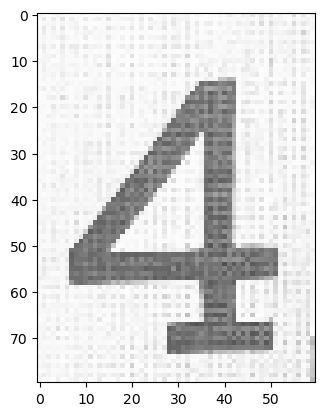

In [207]:
plt.imshow(preprocess_image("manual_imgs/4d.jpg")[0])
plt.show

### Load Data

In [224]:
path_to_images = 'manual_imgs/'
suits = {'h': 0, 'd': 1, 's': 2, 'c': 3}
ranks = {'2': 0, '3': 1, '4': 2, '5': 3, '6': 4, '7': 5, '8': 6, '9': 7, '1': 8, 'j': 9, 'q': 10, 'k': 11, 'a': 12}

X_suit = []
X_rank = []
y_suit = []
y_rank = []

for img_filename in os.listdir(path_to_images):
    y_suit.append(suits[img_filename[1]])
    y_rank.append(ranks[img_filename[0]])
    
    filepath = os.path.join(path_to_images, img_filename)
    rank, suit = preprocess_image(filepath)
    X_rank.append(rank / 255.0) # normalize to [0,1]
    X_suit.append(suit / 255.0) # normalize to [0,1]
    
X_rank = tf.convert_to_tensor(X_rank, dtype=tf.float32)
X_suit = tf.convert_to_tensor(X_suit, dtype=tf.float32)
y_suit = tf.convert_to_tensor(y_suit, dtype=tf.int32)
y_rank = tf.convert_to_tensor(y_rank, dtype=tf.int32)

suit_dataset = tf.data.Dataset.from_tensor_slices((X_suit, y_suit)).shuffle(buffer_size=52).repeat().batch(4).prefetch(tf.data.AUTOTUNE)
rank_dataset = tf.data.Dataset.from_tensor_slices((X_rank, y_rank)).shuffle(buffer_size=52).repeat().batch(4).prefetch(tf.data.AUTOTUNE)

### Build Model

In [211]:
class CardModel(tf.keras.Model):
    def __init__(self, num_classes):
        super(CardModel, self).__init__()
        arcitecture = [
            tf.keras.layers.Input(shape=(80, 60, 3)),
            
            tf.keras.layers.Conv2D(32, (7, 7), padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
            tf.keras.layers.MaxPooling2D((2, 2)),
            
            tf.keras.layers.Conv2D(64, (3, 3)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
            tf.keras.layers.MaxPooling2D((2, 2)),
            
            tf.keras.layers.Flatten(),
            
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(num_classes, activation='softmax'),
        ]
        self.sequential = tf.keras.Sequential(arcitecture)

    def call(self, inputs):
        return self.sequential(inputs)


### Train Model

In [225]:
suit_model = CardModel(num_classes=4)
suit_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

rank_model = CardModel(num_classes=13)
rank_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

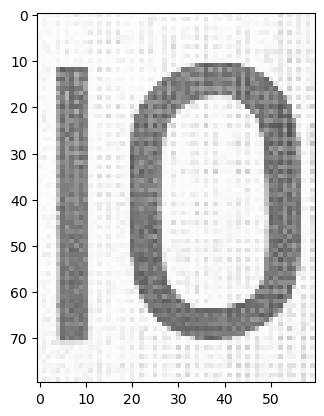

suit:  3
rank:  10


In [217]:
card = 30
plt.imshow(rank_dataset.take(1).as_numpy_iterator().next()[0])
plt.show()
print("suit: ", y_suit[card].numpy())
print("rank: ", y_rank[card].numpy())

In [240]:
rank_model.fit(rank_dataset, 
               epochs=50,
               batch_size=4, 
               steps_per_epoch=100)

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.2266 - loss: 3.0054
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9711 - loss: 0.1109
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 0.0036
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 0.0013
Epoch 5/50
 55/100 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 5.3711e-04

KeyboardInterrupt: 

In [226]:
suit_model.fit(suit_dataset, 
                epochs=100,
                verbose=1,
                batch_size=4,
                steps_per_epoch=50)

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6143 - loss: 1.3965
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 0.0050
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 0.0016
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 1.0635e-04
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 4.7336e-05
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 3.2816e-05
Epoch 7/100
 6/50 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 1.0502e-05

KeyboardInterrupt: 

In [228]:
suit_model.save_weights('cropped_suit_model.weights.h5')

In [241]:
rank_model.save_weights('cropped_rank_model.weights.h5')

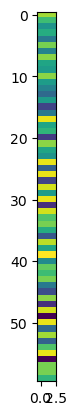

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)

In [247]:
# suits = {'h': 0, 'd': 1, 's': 2, 'c': 3}
# ranks = {'2': 0, '3': 1, '4': 2, '5': 3, '6': 4, '7': 5, '8': 6, '9': 7, '1': 8, 'j': 9, 'q': 10, 'k': 11, 'a': 12}

img = preprocess_image("manual_imgs/4s.jpg")[0]
plt.imshow(img[0])
plt.show()

img = np.expand_dims(img, axis=0) # add batch dimension
#suit_model.predict(img)
rank_model.predict(img)